In [1]:
# !pip install --upgrade fastai torch torchvision torchaudio #--index-url https://download.pytorch.org/whl/cu116

In [2]:
import torch
from torch import nn
print(torch.cuda.is_available())

False


In [3]:
from fastai.collab import CollabDataLoaders, collab_learner
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import numpy as np

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.random.manual_seed(random_seed)
torch.manual_seed(random_seed) # cpu  vars
torch.cuda.manual_seed_all(random_seed) # gpu 
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True  #needed
torch.backends.cudnn.benchmark = False

import warnings

In [4]:
%%bigquery df_blackfriday_data
select * from `blackfridayintelia.blackfriday.blackfriday`

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
# %store -r df_blackfriday_data

## Data Processing

In [6]:
trainset, testset = train_test_split(df_blackfriday_data, random_state=random_seed, test_size=0.25)


In [7]:
ratings_dict = {'item': list(trainset.Product_ID),
                'user': list(trainset.User_ID),
                'rating': list((trainset.Purchase.pow(1/2)- 3.464)/15)}
ratings = pd.DataFrame(ratings_dict)

ratings_test_dict = {'item': list(testset.Product_ID),
                'user': list(testset.User_ID),
                'rating': list((testset.Purchase.pow(1/2) -3.464)/15)}
ratings_test = pd.DataFrame(ratings_test_dict)

In [8]:
ratings.describe()

,user,rating
count,4.125510e+05,412551.000000
mean,1.003032e+06,5.924891
std,1.727880e+03,1.813775
min,1.000001e+06,0.000007
25%,1.001522e+06,4.857179
50%,1.003080e+06,5.749405
75%,1.004480e+06,7.088751
max,1.006040e+06,10.088627


In [9]:
dls = CollabDataLoaders.from_df(ratings, bs=512, seed=random_seed)

/home/jupyter/.local/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


## DL

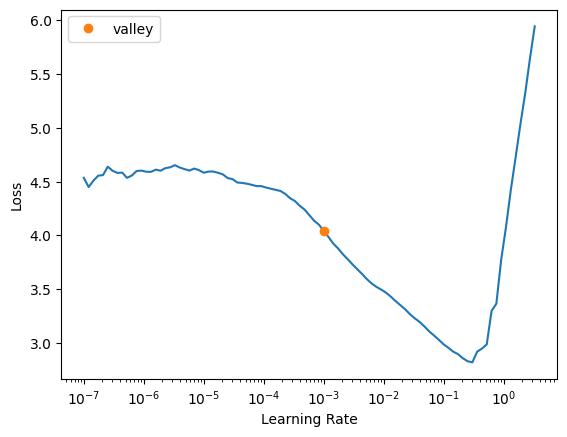

In [37]:
# learn = collab_learner(dls, emb_szs={'user': 5, 'item': 5}, n_factors=10, use_nn=True, y_range=(0, 10))
learn = collab_learner(dls, use_nn=True, y_range=(0, 10))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) 
    learn.lr_find(stop_div=False)
    dir(learn.recorder)

In [38]:
learn.recorder.lr

0.001

In [39]:
# learn = collab_learner(dls, n_factors=160, use_nn=True, y_range=(0, 10))
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(7, lr_max=5e-3, wd=0.7)

# 0.7517
# 5, 5e-3, 0.2
# 0.737
# 5, 5e-3, 0.3
# 0.734
# 6, 5e-3, 0.5
# 0.733564
# 7, 5e-3, 0.7
# 0.731576

epoch,train_loss,valid_loss,time
0,0.922481,0.919931,00:12
1,0.908176,0.889005,00:11
2,0.875914,0.868672,00:11
3,0.847315,0.832944,00:11
4,0.789114,0.790490,00:11
5,0.739048,0.747156,00:12
6,0.655043,0.748261,00:11


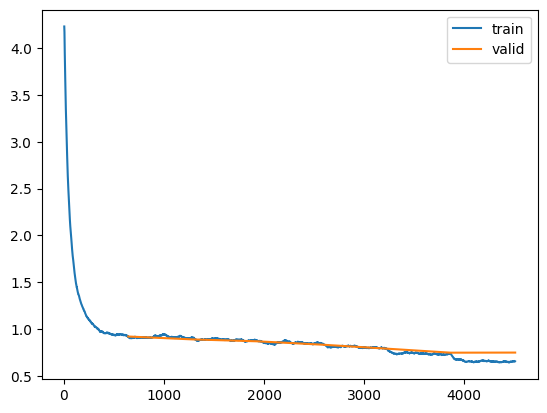

In [40]:
learn.recorder.plot_loss()

In [41]:
eval(learn)

(0.8610748292831572, 2462.7632196028985)

In [42]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(3594, 157)
    (1): Embedding(5891, 207)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=364, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (2): fastai.layers.SigmoidRange(low=0, high=10)
  )
)

## Hyperparameter Tuning

In [26]:
import itertools
from sklearn.metrics import mean_squared_error
from math import sqrt

def eval(learner):
    dl = learner.dls.test_dl(ratings_test, with_labels=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        aaa = learner.get_preds(dl=dl)

    testset['y'] = (testset['Purchase'].pow(1/2) -3.464)/15
    testset['y_pred'] = [x.tolist()[0] for x in aaa[0]]

    scaled_rmse = sqrt(mean_squared_error(testset['y'], testset['y_pred']))
    
    testset['Purchase_pred'] = (testset.y_pred*15 +3.464) * (testset.y_pred*15 +3.464)
    rmse = sqrt(mean_squared_error(testset['Purchase'], testset['Purchase_pred']))
    
    return scaled_rmse, rmse

def randomsearch(parameters, n_iters):
    sample_params = random.sample(sorted(itertools.product(*parameters.values())), n_iters)
    names = parameters.keys()
    
    model_pool = []
    param_pool = []
    srmse_pool = []
    rmse_pool = []
    for i, params in enumerate(sample_params):
        named_params = {x[0]:x[1] for x in zip(names, params)}
        print(i, named_params)
        
        model = learn = collab_learner(dls, n_factors=named_params.get('n_factors'), use_nn=True, y_range=(0, 10))
        with model.no_bar(), model.no_logging(), warnings.catch_warnings():
            warnings.simplefilter("ignore")
            learn.fit_one_cycle(7, lr_max=named_params.get('lr_max'), wd=named_params.get('wd'))
            srmse, rmse = eval(learn)
            print('\tscaled_rmse:', srmse, ', rmse:', rmse)
            param_pool.append(named_params)
            srmse_pool.append(srmse)
            model_pool.append(learn)
            rmse_pool.append(rmse)
            
    min_idx = srmse_pool.index(min(srmse_pool))
    print('best iteration', min_idx)
    print('best performance:', srmse_pool[min_idx], rmse_pool[min_idx])
    print('best parameters:', param_pool[min_idx])
    return model_pool[min_idx], param_pool[min_idx], srmse_pool[min_idx], rmse_pool[min_idx]

In [29]:
parameters = {'n_factors': [140, 160, 180, 200, 250],
             'lr_max': [1e-3, 5e-3, 2e-2],
             'wd':[0.6, 0.7, 0.8]}
learner, params, scaled_rmse, rmse = randomsearch(parameters, 15)

0 {'n_factors': 250, 'lr_max': 0.005, 'wd': 0.7}
	scaled_rmse: 0.8609914679849139 , rmse: 2461.7785179956645
1 {'n_factors': 140, 'lr_max': 0.005, 'wd': 0.6}
	scaled_rmse: 0.8593753679555176 , rmse: 2453.3229534238953
2 {'n_factors': 160, 'lr_max': 0.005, 'wd': 0.8}
	scaled_rmse: 0.8594346447982583 , rmse: 2457.040370529697
3 {'n_factors': 140, 'lr_max': 0.005, 'wd': 0.7}
	scaled_rmse: 0.8602245920209227 , rmse: 2453.8227834579056
4 {'n_factors': 140, 'lr_max': 0.001, 'wd': 0.8}
	scaled_rmse: 0.8965111621418093 , rmse: 2550.10019923723
5 {'n_factors': 180, 'lr_max': 0.005, 'wd': 0.6}
	scaled_rmse: 0.8601443221684926 , rmse: 2458.460005725956
6 {'n_factors': 250, 'lr_max': 0.005, 'wd': 0.8}
	scaled_rmse: 0.8601282316435895 , rmse: 2457.6814176941184
7 {'n_factors': 200, 'lr_max': 0.005, 'wd': 0.8}
	scaled_rmse: 0.8595623420804046 , rmse: 2455.773461129958
8 {'n_factors': 160, 'lr_max': 0.02, 'wd': 0.6}
	scaled_rmse: 0.8676434691660311 , rmse: 2479.742906740124
9 {'n_factors': 160, 'lr_m

In [28]:
from fastai import tabular
tabular.model.get_emb_sz(dls.train_ds, {})

[(3594, 157), (5891, 207)]